# Results for experiments over KDDCup dataset

In [1]:
%matplotlib inline
from IPython.display import display

import matplotlib.pyplot as plt
import numpy
import pandas
import pickle
import os
import re

from sklearn import metrics

In [2]:
import seaborn
seaborn.set_style('white')
seaborn.set_palette('colorblind')

In [3]:
def get_runs(dirname):
    return [run_prediction for run_prediction in os.listdir(dirname)
            if os.path.isfile(os.path.join(dirname, run_prediction)) and 'prediction' in run_prediction]

def get_learning(dirname):
    return [run_prediction for run_prediction in os.listdir(dirname)
            if os.path.isfile(os.path.join(dirname, run_prediction)) and 'performance' in run_prediction]

In [4]:
ANCHOR_COURSES = [1, 6, 16]

In [5]:
def base_metrics_df():
    return pandas.DataFrame(columns=['Experiment', 'Run',
                                     'AUC', 'RMSE', 'APS', 'Accuracy', 'R2'])

In [6]:
def read_file_metrics(filename):
    """Returns a DataFrame with values AUC, RMSE, APS, Accuracy, R2 Score"""
    results = []
    ignored_sequences = 0
    with open(filename, 'rb') as prediction_file:
        true, predicted = pickle.load(prediction_file)
    try:
        results.append([metrics.roc_auc_score(true, predicted)])
    except ValueError:
        ignored_sequences += 1
        results.append([numpy.nan])
    results[-1].append(metrics.mean_squared_error(true, predicted)**0.5)
    results[-1].append(metrics.accuracy_score(true, numpy.where(predicted > 0.5, 1, 0)))
    results[-1].append(metrics.r2_score(true, predicted))
    results[-1].append(true.shape[0])
    if ignored_sequences > 0:    
        print('{} sequences with only one class, ignoring.'.format(ignored_sequences))
    return pandas.DataFrame(results, columns=['AUC', 'RMSE', 'Accuracy', 'R2', 'Support'])

In [7]:
def read_metrics(dirnames):
    metrics_dfs = []
    for dirname in dirnames:
        for filename in get_runs(dirname):
            file_metrics = read_file_metrics(os.path.join(dirname, filename))
            file_metrics['Experiment'] = dirname[-16:]
            file_metrics['Run'] = re.search('.*run(\d+).*', filename).group(1)
            course = re.search('.*_c(\d+)_.*', filename)
            if course is not None:
                file_metrics['Course'] = int(re.search('.*_c(\d+)_.*', filename).group(1))
            else:
                file_metrics['Course'] = 1
            metrics_dfs.append(file_metrics)
    return pandas.concat(metrics_dfs, ignore_index=True).set_index(['Experiment', 'Run', 'Course'])

In [8]:
def read_performances(dirnames):
    results = {}
    for dirname in reversed(dirnames):
        dataframes = []
        for filename in get_learning(dirname):
            with open(os.path.join(dirname, filename), 'rb') as performance_file:
                train, validation = pickle.load(performance_file)
            train = pandas.DataFrame(train, columns=['epoch', 'mse'], dtype=numpy.float32)
            validation = pandas.DataFrame(validation, columns=['epoch', 'mse'], dtype=numpy.float32)
            train['Dataset'] = 'train'
            validation['Dataset'] = 'validation'
            concat = pandas.concat([train, validation])
            concat['Run'] = re.search('.*run(\d+).*', filename).group(1)
            course = re.search('.*_c(\d+)_.*', filename)
            if course is not None:
                concat['Course'] = int(re.search('.*_c(\d+)_.*', filename).group(1))
            else:
                concat['Course'] = 1
            concat['rmse'] = concat['mse']**0.5
            dataframes.append(concat)
        if len(dataframes) > 0:
            results[dirname] = pandas.concat(dataframes) # train.join(validation, lsuffix='_t', rsuffix='_v')
    return results

def graphic_performances(train_performances):
    for dirname, performance_dataframe in train_performances.items():
        print(dirname)
        performance_dataframe['epoch'] = performance_dataframe.epoch.astype(numpy.int)
        grid = seaborn.FacetGrid(data=performance_dataframe.loc[performance_dataframe['Run'] == '0'],
                                 col='Course', despine=True, ylim=[0, 0.5], aspect=1,
                                 palette='colorblind')
        mapped = grid.map(seaborn.pointplot, 'epoch', 'rmse', 'Dataset').add_legend().set_xticklabels([])
        plt.show()

## Experiments with LSTM model

In [8]:
LSTM_EXPERIMENTS_DIRS = [
    '/home/mteruel/edm/results/kddcup/lstm/predictions/17-12-21-09-35/',
    '/home/mteruel/edm/results/kddcup/lstm/predictions/17-12-21-19-47/',
    '/home/mteruel/edm/results/kddcup/lstm/predictions/17-12-21-20-29/',
    '/home/mteruel/edm/results/kddcup/lstm/predictions/17-12-21-20-38/',
]

## Learning curves

In [21]:
lstm_performances = read_performances(LSTM_EXPERIMENTS_DIRS)

/home/mteruel/edm/results/kddcup/lstm/predictions/17-12-21-20-29/


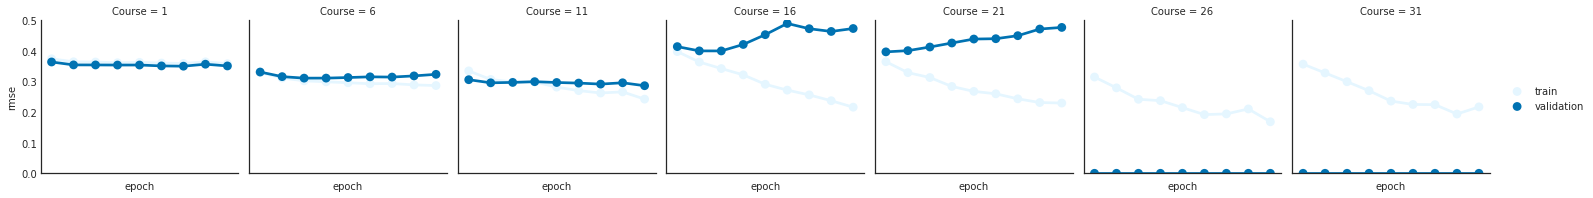

/home/mteruel/edm/results/kddcup/lstm/predictions/17-12-21-20-38/


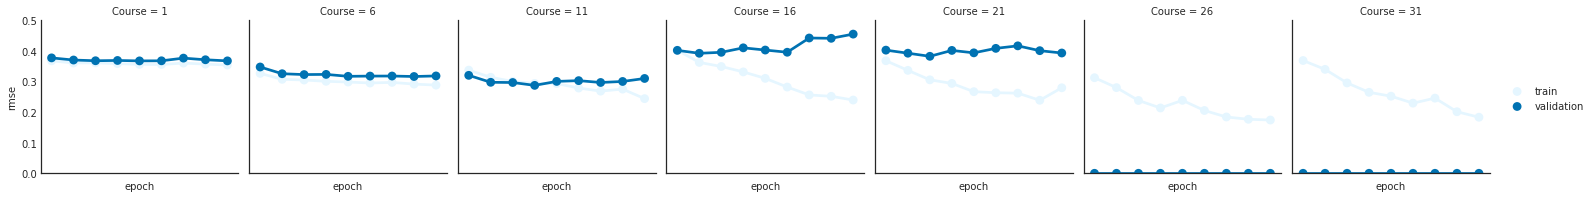

/home/mteruel/edm/results/kddcup/lstm/predictions/17-12-21-19-47/


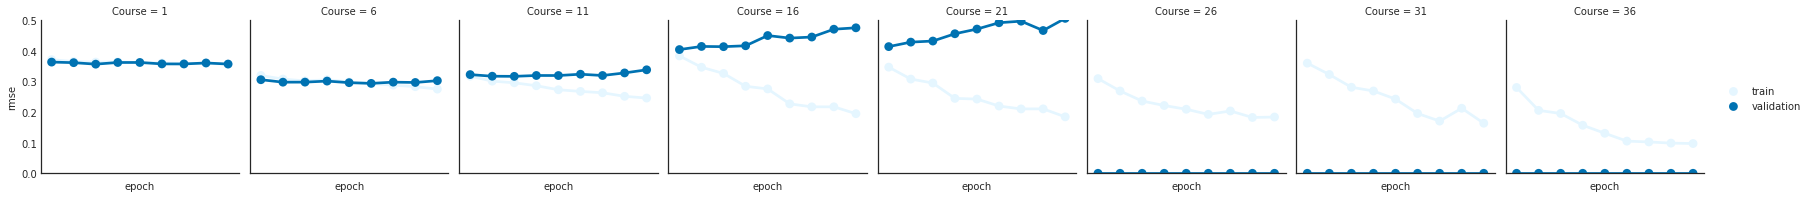

/home/mteruel/edm/results/kddcup/lstm/predictions/17-12-21-09-35/


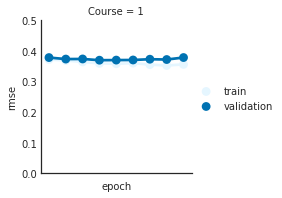

In [74]:
graphic_performances(lstm_performances)

In [39]:
for dirname, dataframe in lstm_performances.items():
    print(dirname)
    idx = dataframe.groupby(['Dataset', 'Course'])['epoch'].transform(max) == dataframe['epoch']
    display(dataframe[idx].groupby(['Course', 'Dataset']).agg('mean'))

/home/mteruel/edm/results/kddcup/lstm/predictions/17-12-21-20-29/


epoch       mse      rmse
Course Dataset                              
1      train         450  0.129004  0.359170
       validation    450  0.121409  0.348428
6      train         450  0.081685  0.285803
       validation    450  0.108711  0.329659
11     train         450  0.060921  0.246787
       validation    450  0.098677  0.313002
16     train         450  0.051872  0.227476
       validation    450  0.231580  0.481166
21     train         450  0.051343  0.226567
       validation    450  0.210983  0.458973
26     train         450  0.038785  0.195128
       validation    450  0.000000  0.000000
31     train         450  0.038495  0.194937
       validation    450  0.000000  0.000000

/home/mteruel/edm/results/kddcup/lstm/predictions/17-12-21-20-38/


epoch       mse      rmse
Course Dataset                              
1      train         450  0.125708  0.354553
       validation    450  0.134682  0.366989
6      train         450  0.081458  0.285393
       validation    450  0.114037  0.337170
11     train         450  0.060200  0.245355
       validation    450  0.089717  0.299333
16     train         450  0.061074  0.247020
       validation    450  0.200879  0.448141
21     train         450  0.068278  0.260605
       validation    450  0.160873  0.401017
26     train         450  0.034599  0.185656
       validation    450  0.000000  0.000000
31     train         450  0.033015  0.181694
       validation    450  0.000000  0.000000

/home/mteruel/edm/results/kddcup/lstm/predictions/17-12-21-19-47/


epoch       mse      rmse
Course Dataset                              
1      train         450  0.127403  0.356935
       validation    450  0.135115  0.367439
6      train         450  0.075062  0.273972
       validation    450  0.100826  0.317209
11     train         450  0.057749  0.240241
       validation    450  0.117212  0.342340
16     train         450  0.040863  0.202023
       validation    450  0.221908  0.471047
21     train         450  0.039027  0.197154
       validation    450  0.209453  0.454697
26     train         450  0.030036  0.172957
       validation    450  0.000000  0.000000
31     train         450  0.021934  0.147167
       validation    450  0.000000  0.000000
36     train         450  0.009486  0.097397
       validation    450  0.000000  0.000000

/home/mteruel/edm/results/kddcup/lstm/predictions/17-12-21-09-35/


epoch       mse      rmse
Course Dataset                              
1      train         450  0.126758  0.356031
       validation    450  0.141730  0.376464

## Performance Metrics

In [147]:
lstm_metrics = read_metrics(LSTM_EXPERIMENTS_DIRS)

In [148]:
lstm_metrics.groupby(['Experiment', 'Course']).aggregate('mean')

AUC      RMSE  Accuracy        R2  Support
Experiment       Course                                                 
/17-12-21-09-35/ 1       0.787016  0.387661  0.795000  0.277935     1300
/17-12-21-19-47/ 1       0.878725  0.358683  0.830588  0.438937     1700
                 6       0.793712  0.344677  0.850000  0.274631      700
                 11      0.757309  0.348093  0.853750  0.104003      400
                 16      0.605285  0.532721  0.671667 -0.307955      300
                 21      0.497556  0.456182  0.770000 -0.430692      300
                 26      0.517241  0.331975  0.890000  0.025567      100
                 31      0.635832  0.495192  0.745000 -0.331887      100
                 36      0.728261  0.302985  0.905000 -0.260744      100
/17-12-21-20-29/ 1       0.880297  0.359114  0.826765  0.438206     1700
                 6       0.801927  0.338676  0.857857  0.296198      700
                 11      0.766045  0.348505  0.847500  0.117414      400
                 16      0.656103  0.511274  0.685000 -0.183175      300
                 21      0.596916  0.414426  0.800000 -0.198924      300
                 26      0.579420  0.309793  0.885000 -0.032537      100
                 31      0.675837  0.425695  0.800000  0.045381      100
/17-12-21-20-38/ 1       0.881006  0.361324  0.822059  0.430561     1700
                 6       0.803861  0.335795  0.863571  0.314949      700
                 11      0.738556  0.357680  0.837500  0.108718      400
                 16      0.666461  0.490281  0.713333 -0.108186      300
                 21      0.626165  0.404719  0.795000 -0.094339      300
                 26      0.674197  0.272854  0.920000  0.198244      100
                 31      0.699818  0.463802  0.775000 -0.062171      100

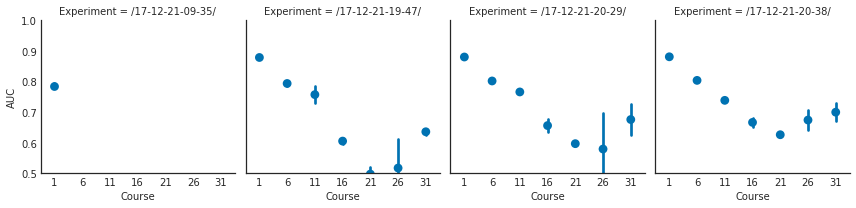

In [168]:
grid = seaborn.FacetGrid(data=lstm_metrics.reset_index(), col='Experiment', col_wrap=4, ylim=[0.5, 1])
grid.map(seaborn.pointplot, 'Course', 'AUC', join=False)

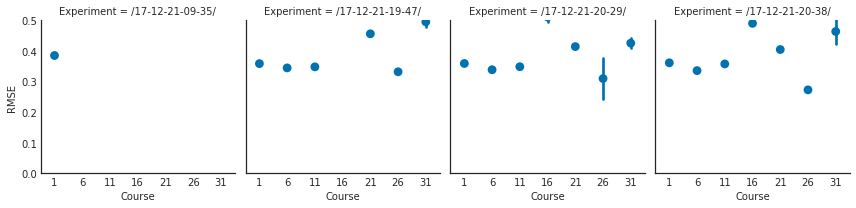

In [169]:
grid = seaborn.FacetGrid(data=lstm_metrics.reset_index(), col='Experiment', col_wrap=4, ylim=[0, 0.5])
grid.map(seaborn.pointplot, 'Course', 'RMSE', join=False)

## Experiments with Embedded LSTM model

In [16]:
EMBEDDING_EXPERIMENTS_DIRS = [
#     '/home/mteruel/edm/results/kddcup/embedding/predictions/17-12-21-09-51/',
#     '/home/mteruel/edm/results/kddcup/embedding/predictions/17-12-21-09-59/',
     '/home/mteruel/edm/results/kddcup/embedding/predictions/17-12-21-10-02/',
#     '/home/mteruel/edm/results/kddcup/embedding/predictions/17-12-21-10-59/',
#     '/home/mteruel/edm/results/kddcup/embedding/predictions/17-12-21-11-05/',
    '/home/mteruel/edm/results/kddcup/embedding/predictions/17-12-21-19-28/',
    '/home/mteruel/edm/results/kddcup/embedding/predictions/17-12-21-21-04/',
    '/home/mteruel/edm/results/kddcup/embedding/predictions/18-01-03-17-53/',
    '/home/mteruel/edm/results/kddcup/embedding/pretrained/predictions/18-01-03-10-28/',
    '/home/mteruel/edm/results/kddcup/embedding/predictions/ongoing-18-01-04-10-51/',
]

## Learning curves

In [17]:
embedding_performances = read_performances(EMBEDDING_EXPERIMENTS_DIRS)

/home/mteruel/edm/results/kddcup/embedding/predictions/17-12-21-10-02/


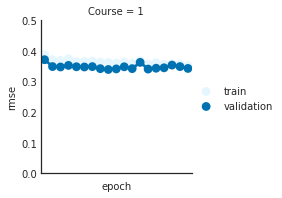

/home/mteruel/edm/results/kddcup/embedding/predictions/17-12-21-21-04/


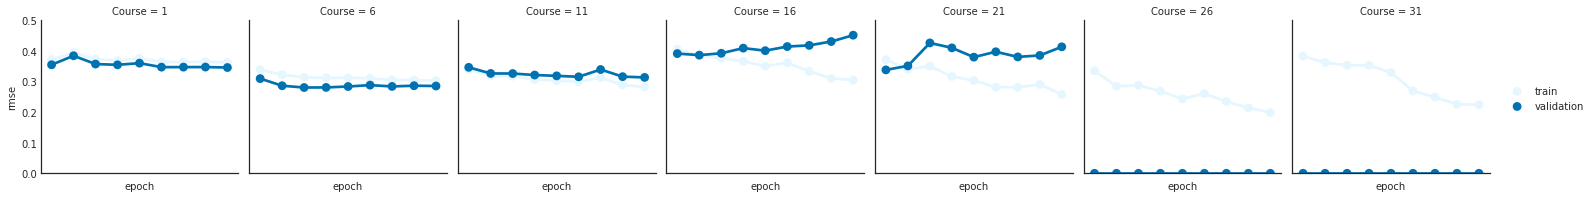

/home/mteruel/edm/results/kddcup/embedding/pretrained/predictions/18-01-03-10-28/


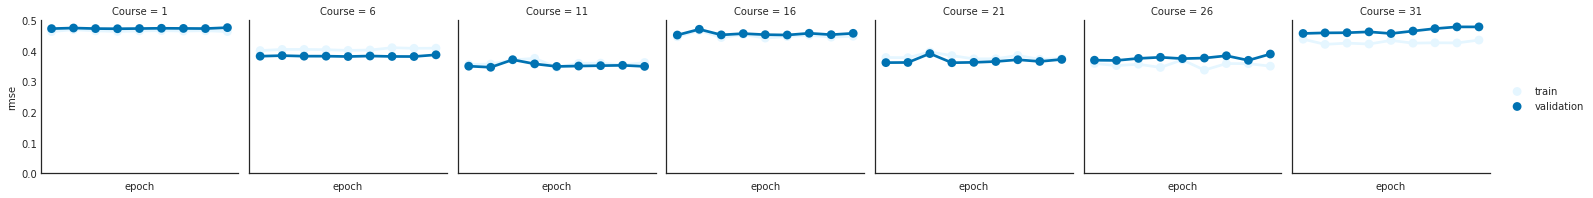

/home/mteruel/edm/results/kddcup/embedding/predictions/ongoing-18-01-04-10-51/


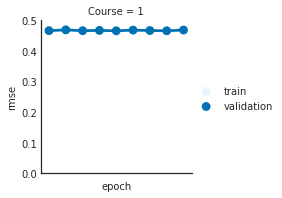

/home/mteruel/edm/results/kddcup/embedding/predictions/17-12-21-19-28/


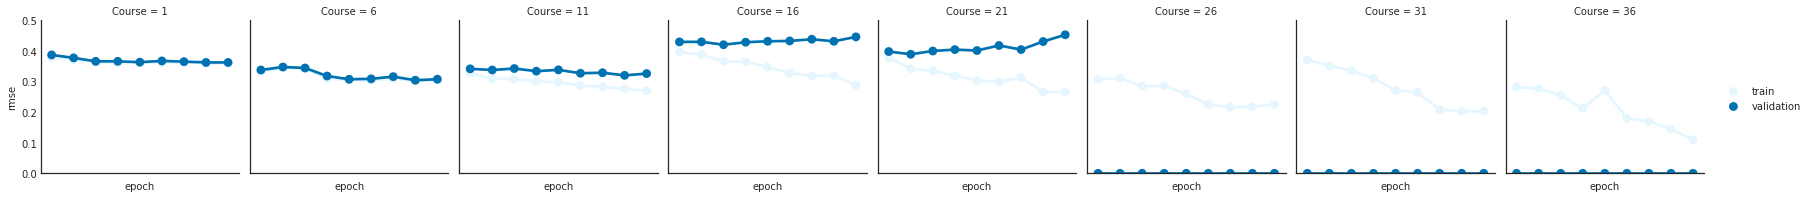

/home/mteruel/edm/results/kddcup/embedding/predictions/18-01-03-17-53/


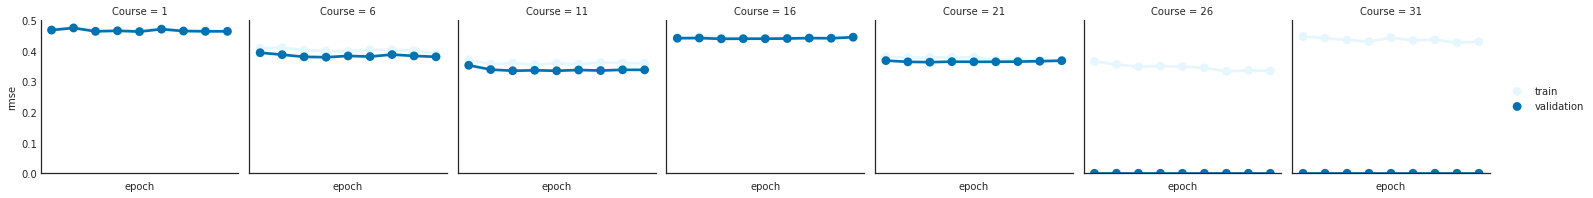

In [18]:
graphic_performances(embedding_performances)

## Performance Metrics

In [12]:
embedding_metrics = read_metrics(EMBEDDING_EXPERIMENTS_DIRS)

In [13]:
embedding_metrics.groupby(['Experiment', 'Course']).aggregate('mean')

AUC      RMSE  Accuracy        R2  Support
Experiment       Course                                                 
/17-12-21-10-02/ 1       0.872731  0.363101  0.823235  0.423740     1700
/17-12-21-19-28/ 1       0.885475  0.352463  0.835882  0.457447     1700
                 6       0.813861  0.334506  0.856429  0.325510      700
                 11      0.772476  0.331415  0.858750  0.154861      400
                 16      0.702617  0.466150  0.723333  0.005979      300
                 21      0.724481  0.393045  0.796667 -0.046897      300
                 26      0.612952  0.331570  0.880000  0.022871      100
                 31      0.681905  0.442748  0.775000  0.058780      100
                 36      0.750000  0.338240  0.875000 -0.559493      100
/17-12-21-21-04/ 1       0.879856  0.358709  0.828529  0.438871     1700
                 6       0.813000  0.331610  0.867143  0.330423      700
                 11      0.802720  0.324250  0.865000  0.206761      400
                 16      0.687272  0.477745  0.705000 -0.052697      300
                 21      0.667932  0.405337  0.810000 -0.141952      300
                 26      0.613207  0.287613  0.915000  0.153520      100
                 31      0.742953  0.480358  0.710000 -0.197190      100
/18-01-03-10-28/ 1       0.727869  0.480953  0.613529 -0.009871     1700
                 6       0.683023  0.390389  0.797857  0.069341      700
                 11      0.558879  0.391875  0.825556 -0.124343      450
                 16      0.640721  0.466775  0.686667  0.003674      300
                 21      0.598595  0.403716  0.773333 -0.112930      300
                 26      0.543786  0.387762  0.813333 -0.497623      150
                 31      0.636123  0.487610  0.673333 -0.207300      150
/18-01-03-17-53/ 1       0.755740  0.459483  0.645294  0.078739     1700
                 6       0.673774  0.430437  0.745714 -0.152570      700
                 11      0.630623  0.378651  0.827500 -0.053911      400
                 16      0.649215  0.461960  0.673333  0.035738      300
                 21      0.534379  0.422017  0.770000 -0.206749      300
                 26      0.588309  0.406959  0.810000 -0.336569      100
                 31      0.517312  0.552985  0.590000 -0.610336      100

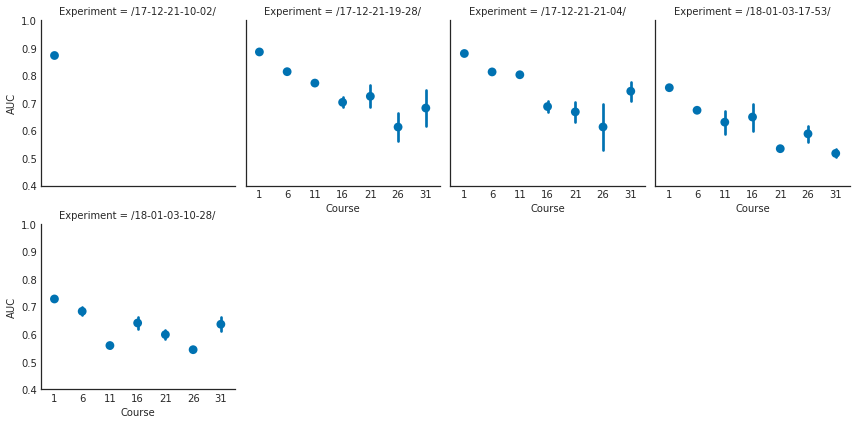

In [14]:
grid = seaborn.FacetGrid(data=embedding_metrics.reset_index(), col='Experiment', col_wrap=4, ylim=[0.4, 1])
grid.map(seaborn.pointplot, 'Course', 'AUC', join=False)

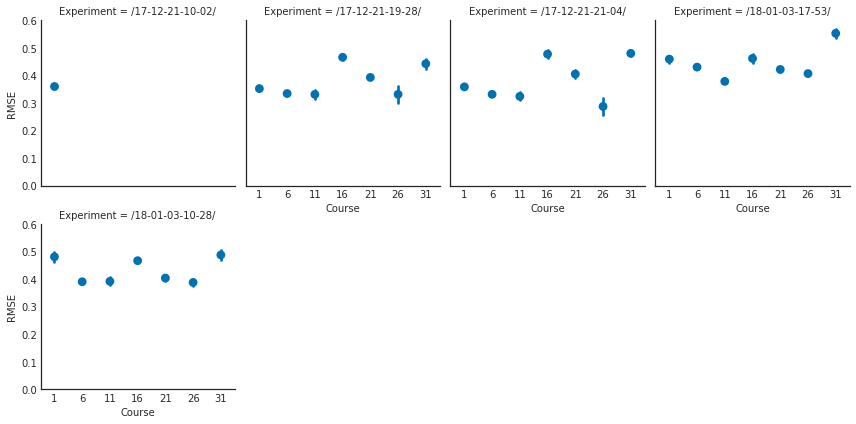

In [15]:
grid = seaborn.FacetGrid(data=embedding_metrics.reset_index(), col='Experiment', col_wrap=4, ylim=[0, 0.6])
grid.map(seaborn.pointplot, 'Course', 'RMSE', join=False)

## Experiments with CO-Embedde LSTM model

In [9]:
COEMBEDDING_EXPERIMENTS_DIRS = [
    #'/home/mteruel/edm/results/kddcup/coembedding/predictions/17-12-21-12-09/',
    '/home/mteruel/edm/results/kddcup/coembedding/predictions/17-12-21-12-57/',
    '/home/mteruel/edm/results/kddcup/coembedding/predictions/17-12-21-20-56/',
    '/home/mteruel/edm/results/kddcup/coembedding/predictions/17-12-21-21-13/',
    '/home/mteruel/edm/results/kddcup/coembedding/predictions/17-12-21-21-22/',
    '/home/mteruel/edm/results/kddcup/coembedding/pretrained/predictions/18-01-03-12-22/',
    '/home/mteruel/edm/results/kddcup/coembedding/predictions/18-01-04-09-45/',
]

## Learning curves

In [10]:
coembedding_performances = read_performances(COEMBEDDING_EXPERIMENTS_DIRS)

/home/mteruel/edm/results/kddcup/coembedding/predictions/18-01-04-09-45/


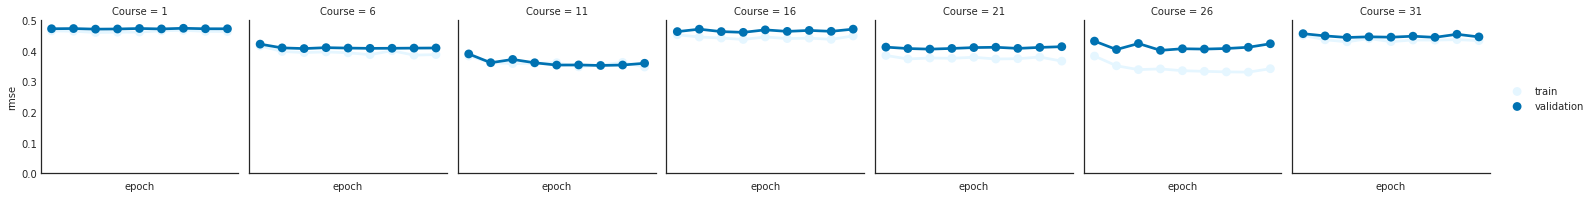

/home/mteruel/edm/results/kddcup/coembedding/predictions/17-12-21-21-13/


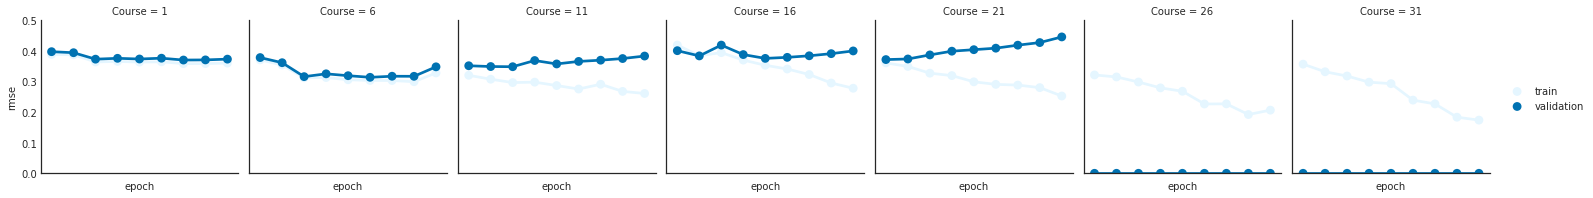

/home/mteruel/edm/results/kddcup/coembedding/predictions/17-12-21-12-57/


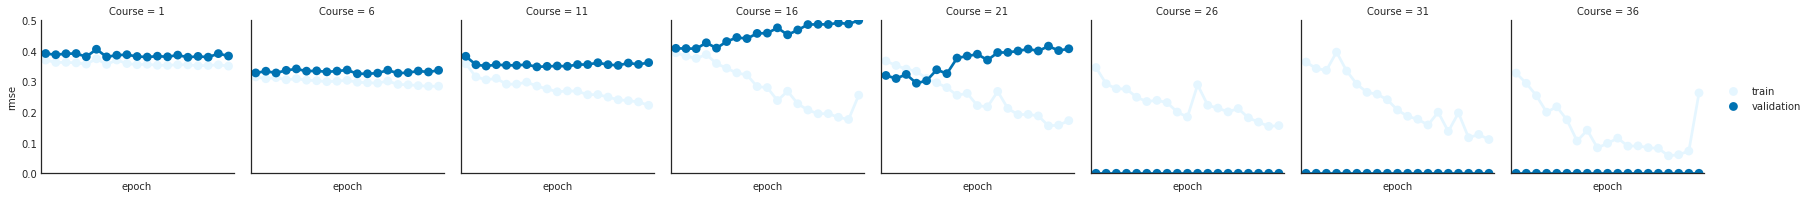

/home/mteruel/edm/results/kddcup/coembedding/predictions/17-12-21-21-22/


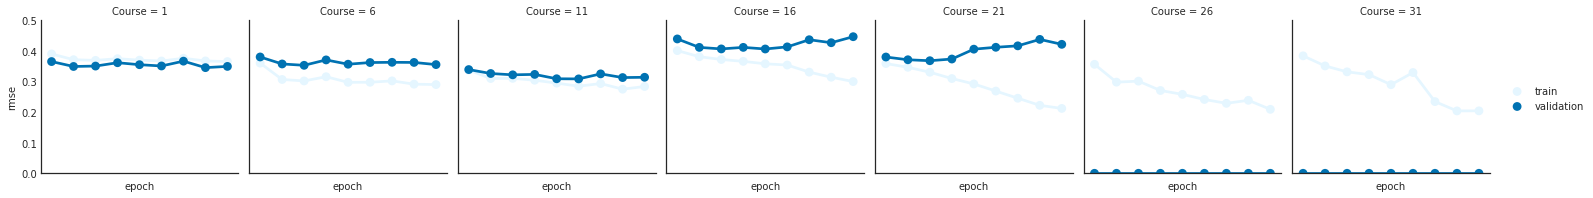

/home/mteruel/edm/results/kddcup/coembedding/predictions/17-12-21-20-56/


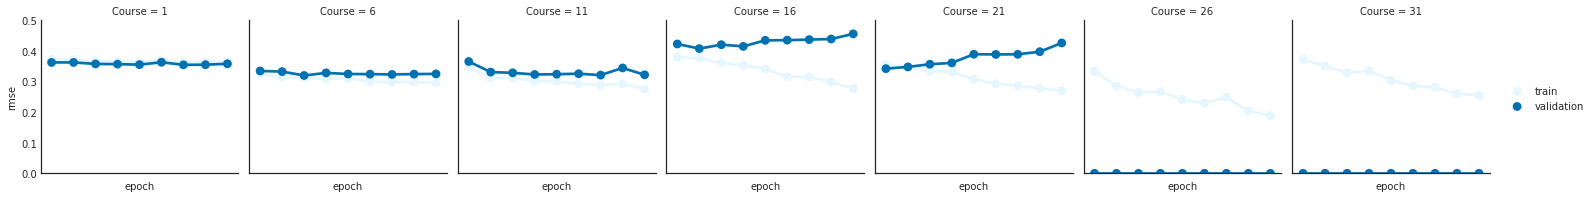

/home/mteruel/edm/results/kddcup/coembedding/pretrained/predictions/18-01-03-12-22/


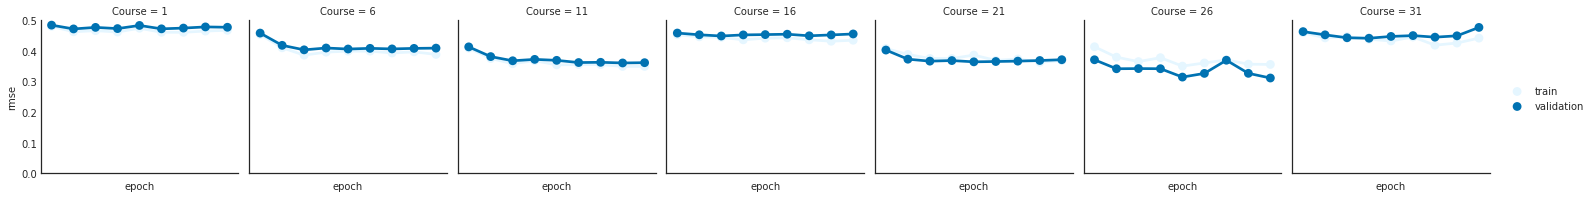

In [11]:
graphic_performances(coembedding_performances)

## Performance Metrics

In [12]:
coembedding_metrics = read_metrics(COEMBEDDING_EXPERIMENTS_DIRS)

In [13]:
coembedding_metrics.groupby(['Experiment', 'Course']).aggregate('mean')

AUC      RMSE  Accuracy        R2  Support
Experiment       Course                                                 
/17-12-21-12-57/ 1       0.881479  0.354323  0.830588  0.452723     1700
                 6       0.789334  0.339435  0.860714  0.286667      700
                 11      0.718432  0.354466  0.841250  0.000265      400
                 16      0.636974  0.514199  0.696667 -0.215102      300
                 21      0.511116  0.447199  0.761667 -0.397071      300
                 26      0.583262  0.320574  0.880000 -0.118200      100
                 31      0.692091  0.468076  0.750000 -0.075312      100
                 36      0.677989  0.323919  0.885000 -0.431937      100
/17-12-21-20-56/ 1       0.881924  0.357166  0.829412  0.443491     1700
                 6       0.809743  0.332709  0.862857  0.320428      700
                 11      0.768551  0.335241  0.853750  0.168948      400
                 16      0.668171  0.482457  0.700000 -0.078948      300
                 21      0.602629  0.393337  0.820000 -0.026320      300
                 26      0.509071  0.330870  0.890000  0.046890      100
                 31      0.739663  0.442096  0.770000  0.016395      100
/17-12-21-21-13/ 1       0.881870  0.356431  0.830294  0.445157     1700
                 6       0.823641  0.332575  0.860000  0.326431      700
                 11      0.780451  0.330146  0.866250  0.198130      400
                 16      0.700847  0.463734  0.698333  0.026581      300
                 21      0.624700  0.404437  0.800000 -0.101327      300
                 26      0.576964  0.298568  0.900000  0.086963      100
                 31      0.751403  0.423996  0.790000  0.114294      100
/17-12-21-21-22/ 1       0.881350  0.359905  0.825000  0.434273     1700
                 6       0.828868  0.329395  0.862857  0.334238      700
                 11      0.784361  0.333325  0.861250  0.188334      400
                 16      0.711660  0.464508  0.725000  0.004241      300
                 21      0.648091  0.387449  0.823333 -0.002714      300
                 26      0.630219  0.285337  0.920000  0.082043      100
                 31      0.737433  0.403082  0.810000  0.147964      100
/18-01-03-12-22/ 1       0.708291  0.484745  0.558824 -0.028212     1700
                 6       0.700335  0.417699  0.707143 -0.059677      700
                 11      0.621845  0.383898  0.812222 -0.115601      450
                 16      0.626745  0.482547  0.626667 -0.067188      300
                 21      0.594129  0.411861  0.766667 -0.127000      300
                 26      0.652768  0.316826  0.873333  0.000275      150
                 31      0.705661  0.509307  0.606667 -0.303134      150
/18-01-04-09-45/ 1       0.698133  0.470199  0.650882  0.037111     1700
                 6       0.663157  0.426747  0.771429 -0.104159      700
                 11      0.600606  0.403779  0.800000 -0.227512      450
                 16      0.695078  0.447739  0.688333  0.083290      300
                 21      0.496825  0.404425  0.811667 -0.126037      300
                 26      0.584773  0.389082  0.783333 -0.368490      150
                 31      0.538646  0.496059  0.610000 -0.229967      150

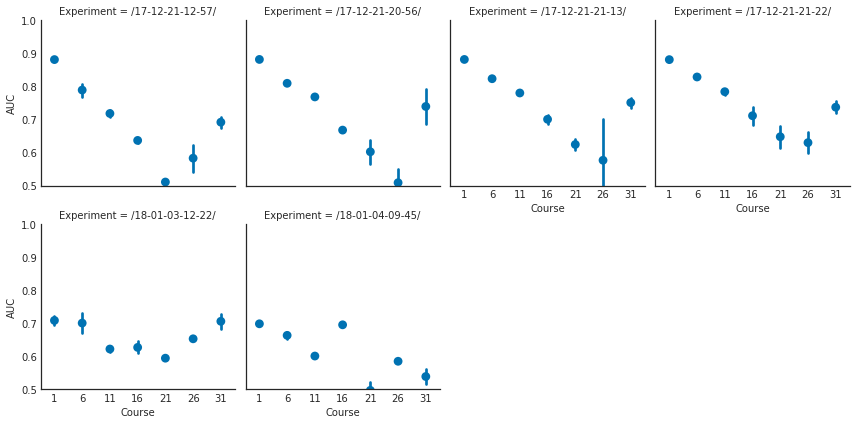

In [14]:
grid = seaborn.FacetGrid(data=coembedding_metrics.reset_index(), col='Experiment', ylim=[0.5, 1], col_wrap=4)
grid.map(seaborn.pointplot, 'Course', 'AUC', join=False)

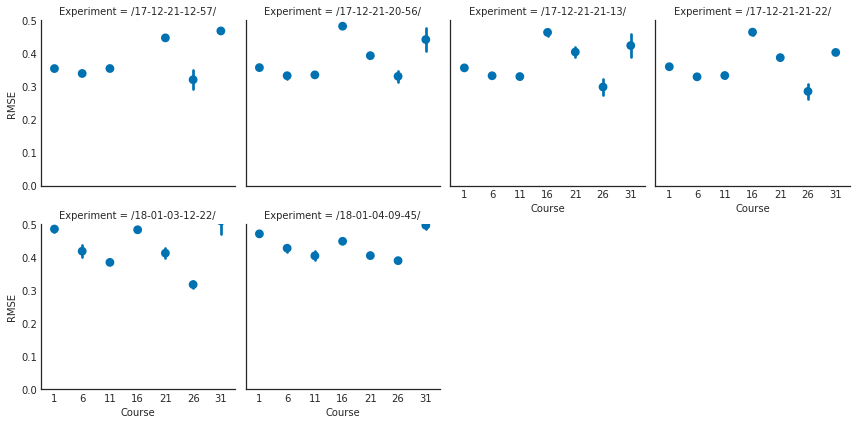

In [15]:
grid = seaborn.FacetGrid(data=coembedding_metrics.reset_index(), col='Experiment', ylim=[0, 0.5], col_wrap=4)
grid.map(seaborn.pointplot, 'Course', 'RMSE', join=False)